In [3]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from transformers import AutoProcessor, Blip2ForConditionalGeneration

%matplotlib inline

## Loading data

In [4]:
transform = transforms.Compose([transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
batch_size = 4
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Visualization

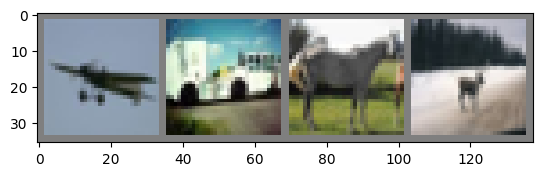

plane truck horse deer 


In [5]:
def imshow(img):
    img = img / 2 + 0.5   
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)
imshow(make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

## CNN

In [6]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = Model()

## Training

In [7]:
def training(count_epoch, criterion, optimizer):
    for epoch in range(count_epoch):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):

            inputs, labels = data

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 2000 == 1999:    
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
                running_loss = 0.0

    print('Training Completed')
    return model

## Testing

In [8]:
def testing(model):
    dataiter = iter(testloader)
    images, labels = next(dataiter)

    imshow(torchvision.utils.make_grid(images))
    print('Target: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(4)))


    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1



    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print(f'Accuracy for the class: {classname} is {accuracy} %')

## Тренируем и тестируем сеть с разными параметрами

- сеть № 1

[1,  2000] loss: 2.041
[1,  4000] loss: 1.800
[1,  6000] loss: 1.715
[1,  8000] loss: 1.645
[1, 10000] loss: 1.578
[1, 12000] loss: 1.576
[2,  2000] loss: 1.507
[2,  4000] loss: 1.516
[2,  6000] loss: 1.474
[2,  8000] loss: 1.479
[2, 10000] loss: 1.473
[2, 12000] loss: 1.442
[3,  2000] loss: 1.419
[3,  4000] loss: 1.413
[3,  6000] loss: 1.394
[3,  8000] loss: 1.375
[3, 10000] loss: 1.372
[3, 12000] loss: 1.356
[4,  2000] loss: 1.332
[4,  4000] loss: 1.359
[4,  6000] loss: 1.284
[4,  8000] loss: 1.321
[4, 10000] loss: 1.302
[4, 12000] loss: 1.294
Training Completed


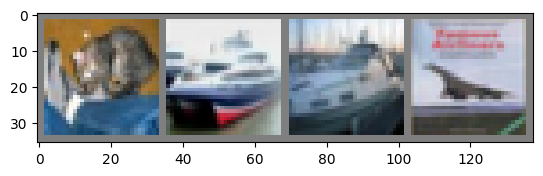

Target:  cat   ship  ship  plane
Predicted:  cat   car   ship  ship 
Accuracy for the class: plane is 52.4 %
Accuracy for the class: car is 68.6 %
Accuracy for the class: bird is 30.5 %
Accuracy for the class: cat is 43.6 %
Accuracy for the class: deer is 44.5 %
Accuracy for the class: dog is 43.3 %
Accuracy for the class: frog is 65.7 %
Accuracy for the class: horse is 53.3 %
Accuracy for the class: ship is 66.0 %
Accuracy for the class: truck is 65.5 %


In [9]:
model = Model()
optimizer=optim.Adam(model.parameters(), lr=0.0001)
trained_model = training(4, nn.CrossEntropyLoss(), optimizer)
testing(trained_model)

- сеть № 2

[1,  2000] loss: 1.917
[1,  4000] loss: 1.624
[1,  6000] loss: 1.546
[1,  8000] loss: 1.486
[1, 10000] loss: 1.454
[1, 12000] loss: 1.433
[2,  2000] loss: 1.365
[2,  4000] loss: 1.329
[2,  6000] loss: 1.324
[2,  8000] loss: 1.310
[2, 10000] loss: 1.303
[2, 12000] loss: 1.284
[3,  2000] loss: 1.213
[3,  4000] loss: 1.211
[3,  6000] loss: 1.206
[3,  8000] loss: 1.229
[3, 10000] loss: 1.228
[3, 12000] loss: 1.217
[4,  2000] loss: 1.136
[4,  4000] loss: 1.135
[4,  6000] loss: 1.151
[4,  8000] loss: 1.142
[4, 10000] loss: 1.150
[4, 12000] loss: 1.157
[5,  2000] loss: 1.079
[5,  4000] loss: 1.090
[5,  6000] loss: 1.083
[5,  8000] loss: 1.109
[5, 10000] loss: 1.105
[5, 12000] loss: 1.114
[6,  2000] loss: 1.030
[6,  4000] loss: 1.054
[6,  6000] loss: 1.062
[6,  8000] loss: 1.022
[6, 10000] loss: 1.087
[6, 12000] loss: 1.073
[7,  2000] loss: 1.004
[7,  4000] loss: 1.017
[7,  6000] loss: 1.002
[7,  8000] loss: 1.025
[7, 10000] loss: 1.037
[7, 12000] loss: 1.044
[8,  2000] loss: 0.953
[8,  4000] 

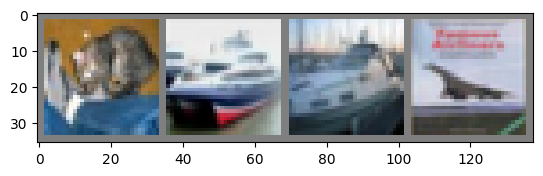

Target:  cat   ship  ship  plane
Predicted:  cat   car   ship  ship 
Accuracy for the class: plane is 54.5 %
Accuracy for the class: car is 66.1 %
Accuracy for the class: bird is 48.4 %
Accuracy for the class: cat is 37.1 %
Accuracy for the class: deer is 51.0 %
Accuracy for the class: dog is 54.3 %
Accuracy for the class: frog is 70.0 %
Accuracy for the class: horse is 65.3 %
Accuracy for the class: ship is 79.7 %
Accuracy for the class: truck is 76.4 %


In [11]:
model = Model()
optimizer=optim.Adam(model.parameters(), lr=0.001)
trained_model = training(8, nn.CrossEntropyLoss(), optimizer)
testing(trained_model)

[1,  2000] loss: 1.877
[1,  4000] loss: 1.601
[1,  6000] loss: 1.522
[1,  8000] loss: 1.484
[1, 10000] loss: 1.431
[1, 12000] loss: 1.405
[2,  2000] loss: 1.327
[2,  4000] loss: 1.315
[2,  6000] loss: 1.317
[2,  8000] loss: 1.320
[2, 10000] loss: 1.280
[2, 12000] loss: 1.270
[3,  2000] loss: 1.206
[3,  4000] loss: 1.202
[3,  6000] loss: 1.187
[3,  8000] loss: 1.189
[3, 10000] loss: 1.196
[3, 12000] loss: 1.192
[4,  2000] loss: 1.121
[4,  4000] loss: 1.118
[4,  6000] loss: 1.129
[4,  8000] loss: 1.140
[4, 10000] loss: 1.139
[4, 12000] loss: 1.131
[5,  2000] loss: 1.041
[5,  4000] loss: 1.069
[5,  6000] loss: 1.062
[5,  8000] loss: 1.099
[5, 10000] loss: 1.061
[5, 12000] loss: 1.114
[6,  2000] loss: 1.000
[6,  4000] loss: 1.009
[6,  6000] loss: 1.040
[6,  8000] loss: 1.043
[6, 10000] loss: 1.043
[6, 12000] loss: 1.070
[7,  2000] loss: 0.973
[7,  4000] loss: 0.991
[7,  6000] loss: 1.004
[7,  8000] loss: 1.008
[7, 10000] loss: 1.020
[7, 12000] loss: 1.008
[8,  2000] loss: 0.935
[8,  4000] 

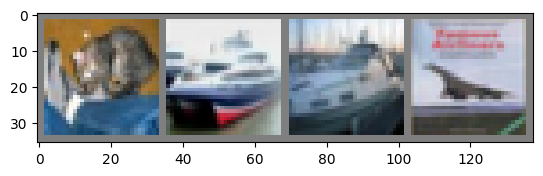

Target:  cat   ship  ship  plane
Predicted:  cat   ship  ship  ship 
Accuracy for the class: plane is 56.9 %
Accuracy for the class: car is 74.8 %
Accuracy for the class: bird is 60.7 %
Accuracy for the class: cat is 37.7 %
Accuracy for the class: deer is 52.4 %
Accuracy for the class: dog is 48.5 %
Accuracy for the class: frog is 66.3 %
Accuracy for the class: horse is 54.6 %
Accuracy for the class: ship is 82.4 %
Accuracy for the class: truck is 59.3 %


In [13]:
model = Model()
optimizer=optim.Adam(model.parameters(), lr=0.001)
trained_model = training(12, nn.CrossEntropyLoss(), optimizer)
testing(trained_model)

[1,  2000] loss: 2.310
[1,  4000] loss: 2.306
[1,  6000] loss: 2.306
[1,  8000] loss: 2.306
[1, 10000] loss: 2.307
[1, 12000] loss: 2.307
[2,  2000] loss: 2.307
[2,  4000] loss: 2.307
[2,  6000] loss: 2.306
[2,  8000] loss: 2.306
[2, 10000] loss: 2.307
[2, 12000] loss: 2.306
[3,  2000] loss: 2.307
[3,  4000] loss: 2.307
[3,  6000] loss: 2.307
[3,  8000] loss: 2.307
[3, 10000] loss: 2.305
[3, 12000] loss: 2.306
[4,  2000] loss: 2.307
[4,  4000] loss: 2.306
[4,  6000] loss: 2.306
[4,  8000] loss: 2.305
[4, 10000] loss: 2.307
[4, 12000] loss: 2.307
[5,  2000] loss: 2.307
[5,  4000] loss: 2.307
[5,  6000] loss: 2.305
[5,  8000] loss: 2.306
[5, 10000] loss: 2.306
[5, 12000] loss: 2.306
[6,  2000] loss: 2.307
[6,  4000] loss: 2.307
[6,  6000] loss: 2.306
[6,  8000] loss: 2.306
[6, 10000] loss: 2.307
[6, 12000] loss: 2.307
[7,  2000] loss: 2.306
[7,  4000] loss: 2.307
[7,  6000] loss: 2.307
[7,  8000] loss: 2.307
[7, 10000] loss: 2.307
[7, 12000] loss: 2.307
[8,  2000] loss: 2.306
[8,  4000] 

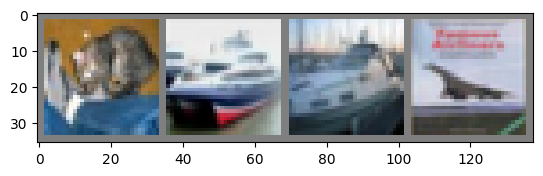

Target:  cat   ship  ship  plane
Predicted:  bird  bird  bird  bird 
Accuracy for the class: plane is 0.0 %
Accuracy for the class: car is 0.0 %
Accuracy for the class: bird is 100.0 %
Accuracy for the class: cat is 0.0 %
Accuracy for the class: deer is 0.0 %
Accuracy for the class: dog is 0.0 %
Accuracy for the class: frog is 0.0 %
Accuracy for the class: horse is 0.0 %
Accuracy for the class: ship is 0.0 %
Accuracy for the class: truck is 0.0 %


In [12]:
model = Model()
optimizer=optim.Adam(model.parameters(), lr=0.01)
trained_model = training(12, nn.CrossEntropyLoss(), optimizer)
testing(trained_model)